In [3]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import pickle

from sklearn.model_selection import train_test_split
from scipy.stats import zscore
from scipy.signal import butter, filtfilt , resample


import tensorflow as tf
from keras import layers , models , utils , callbacks
import random


2025-05-21 15:30:08.937488: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747834209.035521     877 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747834209.061972     877 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747834209.245222     877 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747834209.245276     877 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747834209.245277     877 computation_placer.cc:177] computation placer alr

In [4]:
# Comprobar GPUs disponibles

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available: 1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Visualización de datos : 

Se plotea 10 beats aleatorios, 2 segundos de muestras ruidosas (360Hz * 2  = 720 medidas). Es el tamaño con el que alimentaremos la RNA.
Para elegir otro usuario modifiar la llamada a la funciñon "record_name" 

Total anotaciones tipo '~' encontradas: 43


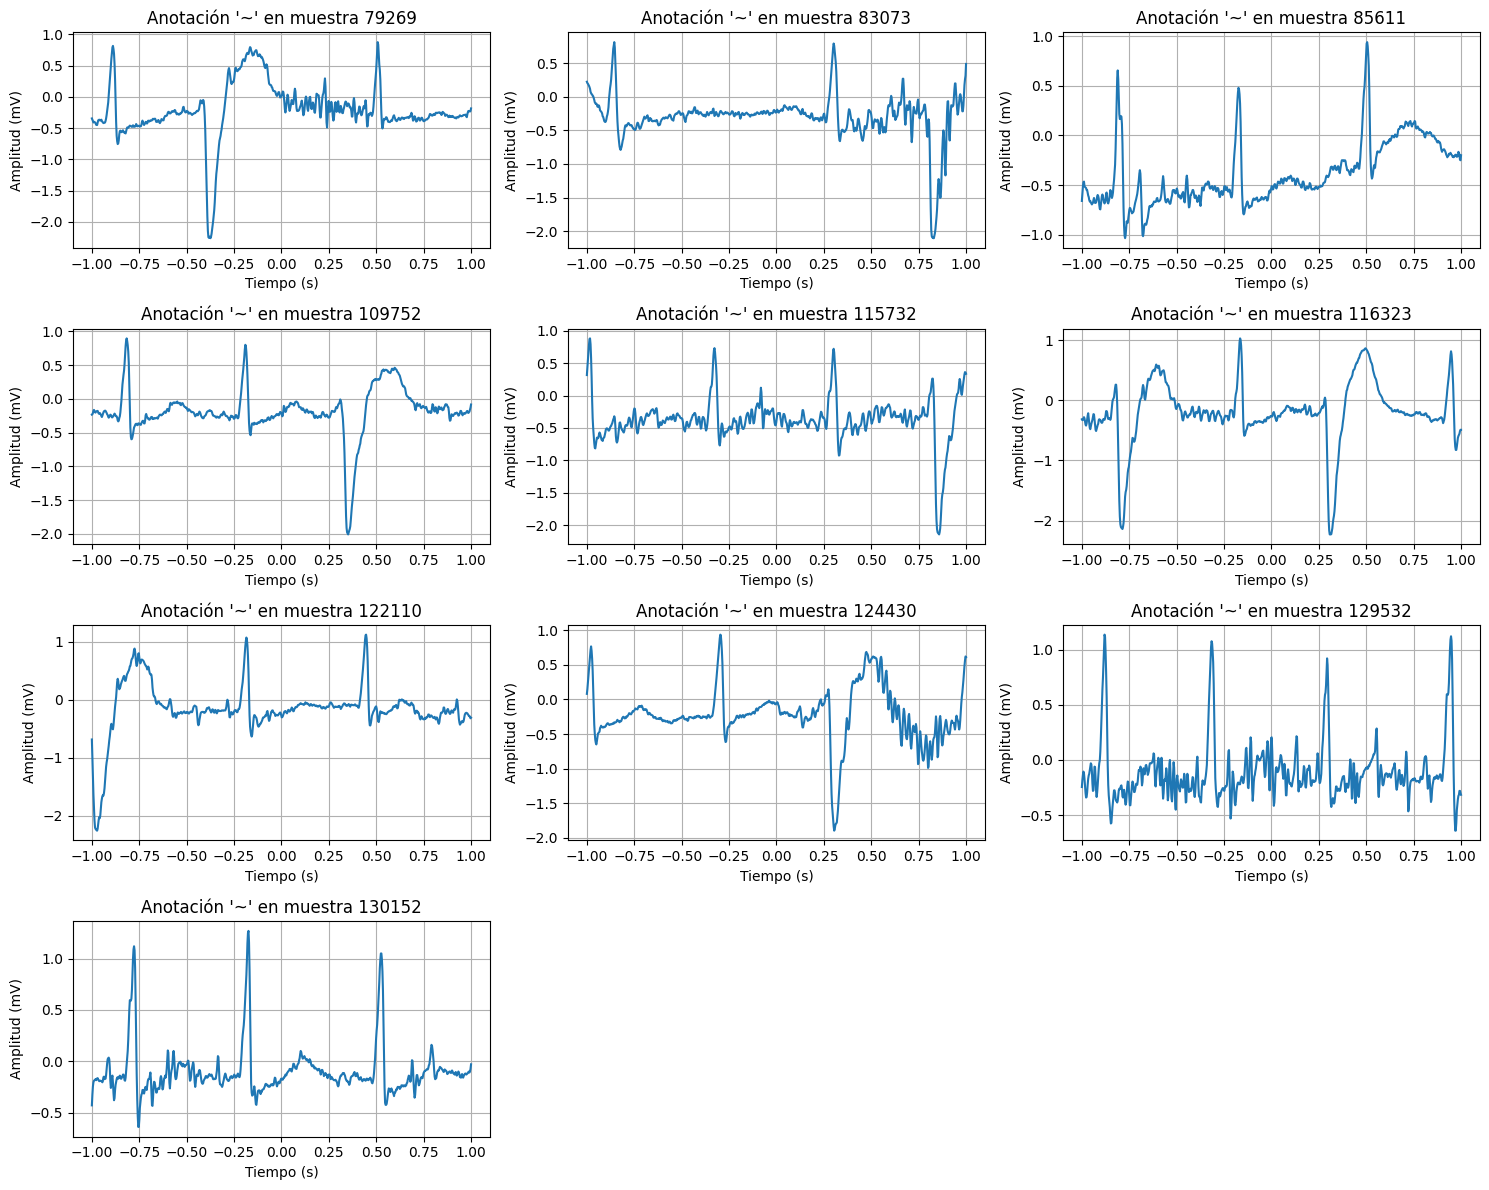

In [3]:
def plot_non_paced_beats(record_name, max_beats=10, window_sec=1):
    # Cargar registro y anotaciones
    record = wfdb.rdrecord(record_name, pn_dir='mitdb')
    annotation = wfdb.rdann(record_name, 'atr', pn_dir='mitdb')

    signal = record.p_signal[:, 0]  # Canal MLII
    fs = record.fs
    margin = int(window_sec * fs)

    # Filtrar anotaciones que no son marcapasos ('/')
    clean_indices = [
        idx for idx, sym in zip(annotation.sample, annotation.symbol)
        if (sym == '~') and idx > margin and idx + margin < len(signal)
    ]

    print(f"Total anotaciones tipo '~' encontradas: {len(clean_indices)}")

    # Determinar disposición de subplots
    cols = 3
    rows = math.ceil(min(max_beats, len(clean_indices)) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
    axes = axes.flatten()

    # Graficar
    for i, idx in enumerate(clean_indices[:max_beats]):
        segment = signal[idx - margin: idx + margin]
        time_axis = np.linspace(-window_sec, window_sec, len(segment))

        ax = axes[i]
        ax.plot(time_axis, segment)
        ax.set_title(f"Anotación '~' en muestra {idx}")
        ax.set_xlabel("Tiempo (s)")
        ax.set_ylabel("Amplitud (mV)")
        ax.grid(True)

    # Eliminar ejes vacíos si hay menos gráficos que subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Modificar record name "200"
plot_non_paced_beats("200", max_beats=10, window_sec=1)


- Igual que el caso anterior pero con señales limpias. Quitamos simbolos ruidosos

Total anotaciones limpias detectadas: 125


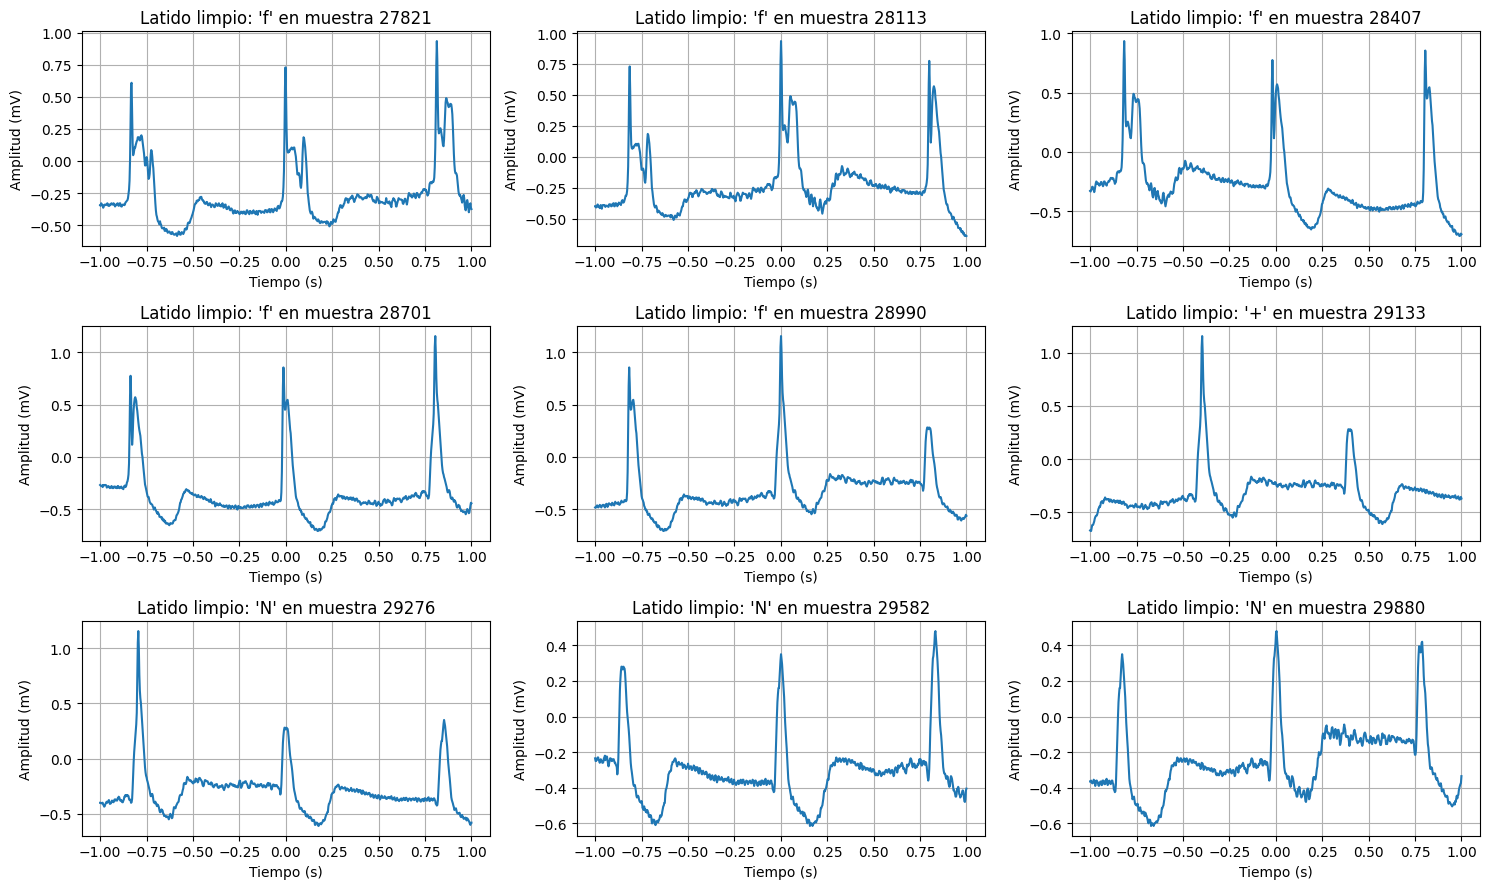

In [4]:
def is_clean_annotation(symbol, subtyp):
    bad_symbols = {'~', 'U', 'T', '|', '/', '^', 'Q'}

    if symbol in bad_symbols:
        return False

    if symbol == '~':
        noisy_mask = 0b00001111
        unreadable_mask = 0b11110000
        if (subtyp & noisy_mask) != 0 or (subtyp & unreadable_mask) != 0:
            return False

    return True

def plot_clean_beats(record_name, max_beats=9, window_sec=1, margin_sec=1):
    record = wfdb.rdrecord(record_name, pn_dir='mitdb')
    annotation = wfdb.rdann(record_name, 'atr', pn_dir='mitdb')

    signal = record.p_signal[:, 0]  
    fs = record.fs
    margin = int(margin_sec * fs)
    half_window = int(window_sec * fs)

    clean_beats = []
    bad_zones = []

    for sample, symbol, subtyp in zip(annotation.sample, annotation.symbol, annotation.subtype):
        if not is_clean_annotation(symbol, subtyp):
            bad_zones.append((sample - margin, sample + margin))

    for sample, symbol, subtyp in zip(annotation.sample, annotation.symbol, annotation.subtype):
        if is_clean_annotation(symbol, subtyp) and sample > half_window and sample + half_window < len(signal):
            in_bad_zone = any(start <= sample <= end for start, end in bad_zones)
            if not in_bad_zone:
                clean_beats.append((sample, symbol))

    print(f"Total anotaciones limpias detectadas: {len(clean_beats)}")

    cols = 3
    rows = math.ceil(min(max_beats, len(clean_beats)) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axes = axes.flatten()

    for i, (sample, symbol) in enumerate(clean_beats[:max_beats]):
        segment = signal[sample - half_window: sample + half_window]
        time_axis = np.linspace(-window_sec, window_sec, len(segment))

        ax = axes[i]
        ax.plot(time_axis, segment)
        ax.set_title(f"Latido limpio: '{symbol}' en muestra {sample}")
        ax.set_xlabel("Tiempo (s)")
        ax.set_ylabel("Amplitud (mV)")
        ax.grid(True)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


plot_clean_beats("102", max_beats=9)

### Procesado de datos 

- Excluimos los siguientes index por ser ruidosos : excluded_records = {'203', '205', '222', '228', '232', '107', '108', '114' , '121'}

- Guardamos las señales manteniendo todas las anotaciones de la base de datos por si las necesitamos en un futuro y las dividimos en muestras de 720 (2 segundos)


In [5]:
def is_annotation_clean(symbol, subtyp):
    bad_symbols = {'~', 'U', 'T', '|', '^', 'MISSB', 'PSE', 'x', 'Q'}
    if symbol in bad_symbols:
        return False
    if symbol == '~':
        noisy_mask = 0b00001111
        unreadable_mask = 0b11110000
        return (subtyp & noisy_mask == 0) and (subtyp & unreadable_mask == 0)
    return True

def extract_symbol_groups(record_list, fs=360):
    all_segments = []
    all_labels = []
    noisy_labels = []

    for record_name in record_list:
        print(f"Procesando {record_name}...")
        try:
            record = wfdb.rdrecord(record_name, pn_dir='mitdb')
            annotation = wfdb.rdann(record_name, 'atr', pn_dir='mitdb')
            
            signal = record.p_signal[:, 0]
            samples = annotation.sample
            symbols = annotation.symbol
            subtypes = annotation.subtype
            channels = annotation.chan
            nums = annotation.num
            aux = annotation.aux_note if hasattr(annotation, 'aux_note') else [''] * len(samples)

            current_group = []
            for i in range(len(samples)):
                symbol = symbols[i]
                subtyp = subtypes[i]

                if is_annotation_clean(symbol, subtyp):
                    current_group.append(i)
                else:
                    if len(current_group) > 1:
                        first = current_group[0]
                        last = current_group[-1]
                        start_sample = samples[first]
                        end_sample = samples[last]

                        for window_start in range(start_sample, end_sample - 2*fs + 1, 60):
                            window_end = window_start + 2*fs
                            if window_end > len(signal):
                                break
                            segment = signal[window_start:window_end]
                            all_segments.append(segment)
                            all_labels.append({
                                "record": record_name,
                                "symbol": symbols[first],
                                "sample": window_start,
                                "subtyp": subtypes[first],
                                "chan": channels[first],
                                "num": nums[first],
                                "aux": aux[first]
                            })
                    # guardar ruidosa
                    noisy_labels.append({
                        "record": record_name,
                        "symbol": symbol,
                        "sample": samples[i],
                        "subtyp": subtyp,
                        "chan": channels[i],
                        "num": nums[i],
                        "aux": aux[i]
                    })
                    current_group = []

            if len(current_group) > 1:
                first = current_group[0]
                last = current_group[-1]
                start_sample = samples[first]
                end_sample = samples[last]

                for window_start in range(start_sample, end_sample - 2*fs + 1, 60):
                    window_end = window_start + 2*fs
                    if window_end > len(signal):
                        break
                    segment = signal[window_start:window_end]
                    all_segments.append(segment)
                    all_labels.append({
                        "record": record_name,
                        "symbol": symbols[first],
                        "sample": window_start,
                        "subtyp": subtypes[first],
                        "chan": channels[first],
                        "num": nums[first],
                        "aux": aux[first]
                    })

        except Exception as e:
            print(f"Error procesando {record_name}: {e}")

    df_signals = pd.DataFrame(all_segments)
    df_labels = pd.DataFrame(all_labels)
    df_noisy = pd.DataFrame(noisy_labels)
    
    return df_signals, df_labels, df_noisy



In [6]:
# Lista completa de registros en MIT-BIH
all_records = [
    '100','101','102','103','104','105','106','107','108','109','111','112','113','114','115','116','117','118','119','121','122','123','124',
    '200','201','202','203','205','207','208','209','210','212','213','214','215','217','219','220','221','222','223','228','230','231','232','233','234'
]

# Registros a excluir (por calidad o problemas conocidos). El 100 y el 103 lo excluimos para poder comparar a posteriori. 
excluded_records = {'203', '205', '222', '228', '232', '107', '108', '114','121','100','103'}

# Filtramos los válidos
valid_records = sorted([rec for rec in all_records if rec not in excluded_records])

print("Registros válidos:", valid_records)
print("Total registros válidos:", len(valid_records))

Registros válidos: ['101', '102', '104', '105', '106', '109', '111', '112', '113', '115', '116', '117', '118', '119', '122', '123', '124', '200', '201', '202', '207', '208', '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', '223', '230', '231', '233', '234']
Total registros válidos: 37


In [8]:
# Construir dataset
df_signals, df_labels , df_noisy = extract_symbol_groups(valid_records)

df_sig_train, df_sig_temp, df_lab_train, df_lab_temp = train_test_split(
    df_signals, df_labels,
    test_size=0.30,
    random_state=42,
    shuffle=True
)

df_sig_val, df_sig_test, df_lab_val, df_lab_test = train_test_split(
    df_sig_temp, df_lab_temp,
    test_size=0.50,
    random_state=42,
    shuffle=True
)

print("Ventanas entrenamiento:", len(df_sig_train))
print("Ventanas validación:", len(df_sig_val))
print("Ventanas test:", len(df_sig_test))

Procesando 101...
Procesando 102...
Procesando 104...
Procesando 105...
Procesando 106...
Procesando 109...
Procesando 111...
Procesando 112...
Procesando 113...
Procesando 115...
Procesando 116...
Procesando 117...
Procesando 118...
Procesando 119...
Procesando 122...
Procesando 123...
Procesando 124...
Procesando 200...
Procesando 201...
Procesando 202...
Procesando 207...
Procesando 208...
Procesando 209...
Procesando 210...
Procesando 212...
Procesando 213...
Procesando 214...
Procesando 215...
Procesando 217...
Procesando 219...
Procesando 220...
Procesando 221...
Procesando 223...
Procesando 230...
Procesando 231...
Procesando 233...
Procesando 234...
Ventanas entrenamiento: 273293
Ventanas validación: 58563
Ventanas test: 58563


- Guardamos en formato pickle para no tener que generarlo cada vez

In [9]:
"""
df_signals_train.to_pickle("ecg_signals_train.pkl")
df_signals_val.to_pickle("ecg_signals_val.pkl")
df_labels_train.to_pickle("ecg_labels_train.pkl")
df_labels_val.to_pickle("ecg_labels_val.pkl")
"""

df_sig_train.to_pickle("ecg_signals_train_1.pkl")
df_sig_val.to_pickle("ecg_signals_val_1.pkl")
df_sig_test.to_pickle("ecg_signals_test_1.pkl")
df_lab_train.to_pickle("ecg_labels_train_1.pkl")
df_lab_val.to_pickle("ecg_labels_val_1.pkl")
df_lab_test.to_pickle("ecg_labels_test_1.pkl")

- Cargamos del archivo

In [5]:

df_sig_train = pd.read_pickle("ecg_signals_train_1.pkl")
df_sig_val = pd.read_pickle("ecg_signals_val_1.pkl")
df_sig_test = pd.read_pickle("ecg_signals_test_1.pkl")
df_lab_train = pd.read_pickle("ecg_labels_train_1.pkl")
df_lab_val = pd.read_pickle("ecg_labels_val_1.pkl")
df_lab_test = pd.read_pickle("ecg_labels_test_1.pkl")
"""
df_signals_train = pd.read_pickle("ecg_signals_train.pkl")
df_signals_val   = pd.read_pickle("ecg_signals_val.pkl")

df_labels_train  = pd.read_pickle("ecg_labels_train.pkl")
df_labels_val    = pd.read_pickle("ecg_labels_val.pkl")
"""

'\ndf_signals_train = pd.read_pickle("ecg_signals_train.pkl")\ndf_signals_val   = pd.read_pickle("ecg_signals_val.pkl")\n\ndf_labels_train  = pd.read_pickle("ecg_labels_train.pkl")\ndf_labels_val    = pd.read_pickle("ecg_labels_val.pkl")\n'

- Se plotean 9 muestras aleatoria para asegurar que el procesado de datos se ha hecho bien

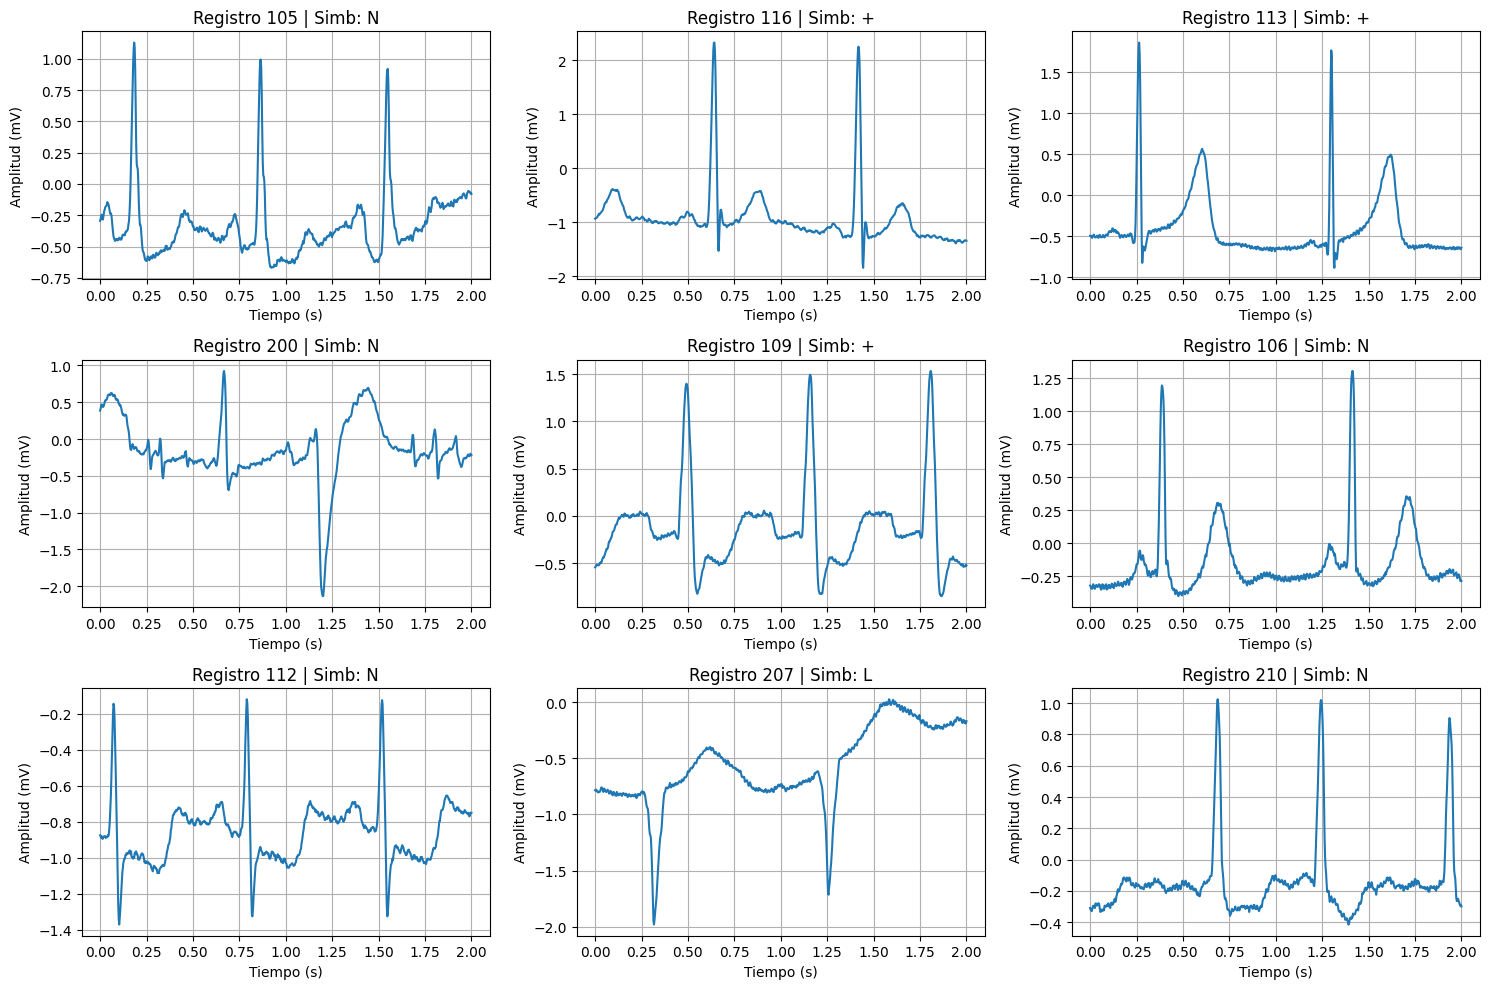

In [6]:
random_indices = np.random.choice(df_sig_train.index, size=9, replace=False)


fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()

for i, idx in enumerate(random_indices):
    signal = df_sig_train.loc[idx]
    label = df_lab_train.loc[idx]
    t = np.linspace(0, len(signal)/360, len(signal))  # Asume fs = 360 Hz

    ax = axes[i]
    ax.plot(t, signal)
    ax.set_title(f"Registro {label['record']} | Simb: {label['symbol']}")
    ax.set_xlabel("Tiempo (s)")
    ax.set_ylabel("Amplitud (mV)")
    ax.grid(True)


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Generar ruido Gaussiano aleatorio

Preparamos ecuaciones para generar ruido

- Genero 4 tipos de ruido. Ruido Gaussiano con diferente nivel en dB . Imitación de lo observado en la PCB de ruido BW , MA y PWI 
- Cuando tenga el PCB final , refinar con el ruido presente en la nueva versión aumentando la frecuencia del filtro paso bajo (de 40 a 100Hz) y disminuyendo la ganacia (de 1100 a 110) para evitar que sature

In [7]:

def calculate_power(signal):
    return np.mean(np.square(signal))

def add_awgn_snr(signal, snr_db):
    signal_power = calculate_power(signal)
    snr_linear = 10 ** (snr_db / 10)
    noise_power = signal_power / snr_linear
    noise = np.random.normal(0, np.sqrt(noise_power), len(signal))
    return signal + noise


def add_powerline_interference(signal, freq=60, snr_db=0, sampling_rate=360):
    t = np.arange(len(signal)) / sampling_rate
    sine_wave = np.sin(2 * np.pi * freq * t)
    signal_power = calculate_power(signal)
    snr_linear = 10 ** (snr_db / 10)
    noise_power = signal_power / snr_linear
    sine_amplitude = np.sqrt(noise_power)
    return signal + sine_amplitude * sine_wave


def add_baseline_wander(signal, sampling_rate=360):

    N = len(signal)
    t = np.arange(N) / sampling_rate


    f1 = np.random.uniform(0.05, 0.5)    
    f2 = np.random.uniform(0.01, 0.05)   

    A1 = np.random.uniform(0.5, 5.0)
    A2 = np.random.uniform(0.1, 1.0)

    env1 = 0.5 * (1 - np.cos(2*np.pi*t / t[-1]))
    env2 = 0.5 * (1 - np.cos(4*np.pi*t / t[-1]))

    drift = (A1 * env1 * np.sin(2*np.pi * f1 * t) +
             A2 * env2 * np.sin(2*np.pi * f2 * t))

    return signal + drift


def add_muscle_artifact(signal, sampling_rate=360):
    N = len(signal)                  # aquí N = 720
    dur_s = np.random.uniform(0.1, 1.2)
    duration = int(dur_s * sampling_rate)
    start = np.random.randint(0, N - duration)

    t = np.arange(duration) / sampling_rate

    artifact = np.zeros(duration)
    for _ in range(10):
        freq  = np.random.uniform(10, 50)
        phase = np.random.uniform(0, 2*np.pi)
        amp   = np.random.uniform(0.05, 0.2)
        artifact += amp * np.sin(2*np.pi * freq * t + phase)

    out = signal.copy()
    out[start:start+duration] += artifact
    return out


def apply_random_noise_type(signal_list):
    noisy_signals = []
    clean_signals = []
    noise_types = []

    for signal in signal_list:
        noise_type = np.random.choice(['AWGN', 'BW', 'PWI', 'MA'])

        if noise_type == 'AWGN':
            snr = np.random.choice([0, 5, 10, 15])
            noisy = add_awgn_snr(signal, snr)
        elif noise_type == 'BW':
            noisy = add_baseline_wander(signal)
        elif noise_type == 'PWI':
            snr = np.random.uniform(20, 30)
            noisy = add_powerline_interference(signal, snr_db=snr)
        elif noise_type == 'MA':
            noisy = add_muscle_artifact(signal)
        
        noisy_signals.append(noisy)
        clean_signals.append(signal)
        noise_types.append(noise_type)

    return np.array(noisy_signals), np.array(clean_signals), noise_types


Añadimos el ruido de manera random a el conjunto de validación y entrenamiento. Usamos Zscore para normalizar antes de alimentar a la red

In [8]:
snr_levels = [0, 5, 10, 15]

signals_train = df_sig_train.values.tolist()
signals_val   = df_sig_val.values.tolist()
signals_test  = df_sig_test.values.tolist()

X_train, y_train, noise_types_train = apply_random_noise_type(df_sig_train.values)
X_val,   y_val,   noise_types_val   = apply_random_noise_type(df_sig_val.values)
X_test,  y_test,  noise_types_test = apply_random_noise_type(df_sig_val.values)

X_train_np = np.array(X_train)
y_train_np = np.array(y_train)

X_val_np = np.array(X_val)
y_val_np = np.array(y_val)

X_test_np = np.array(X_test)
y_test_np = np.array(y_test)


X_train = X_train[..., np.newaxis]
y_train = y_train[..., np.newaxis]
X_val   = X_val[..., np.newaxis]
y_val   = y_val[..., np.newaxis]
X_test   = X_test[..., np.newaxis]
y_test   = y_test[..., np.newaxis]

Ploteamos de manera random para comprobar que hemos añadido bien el ruido

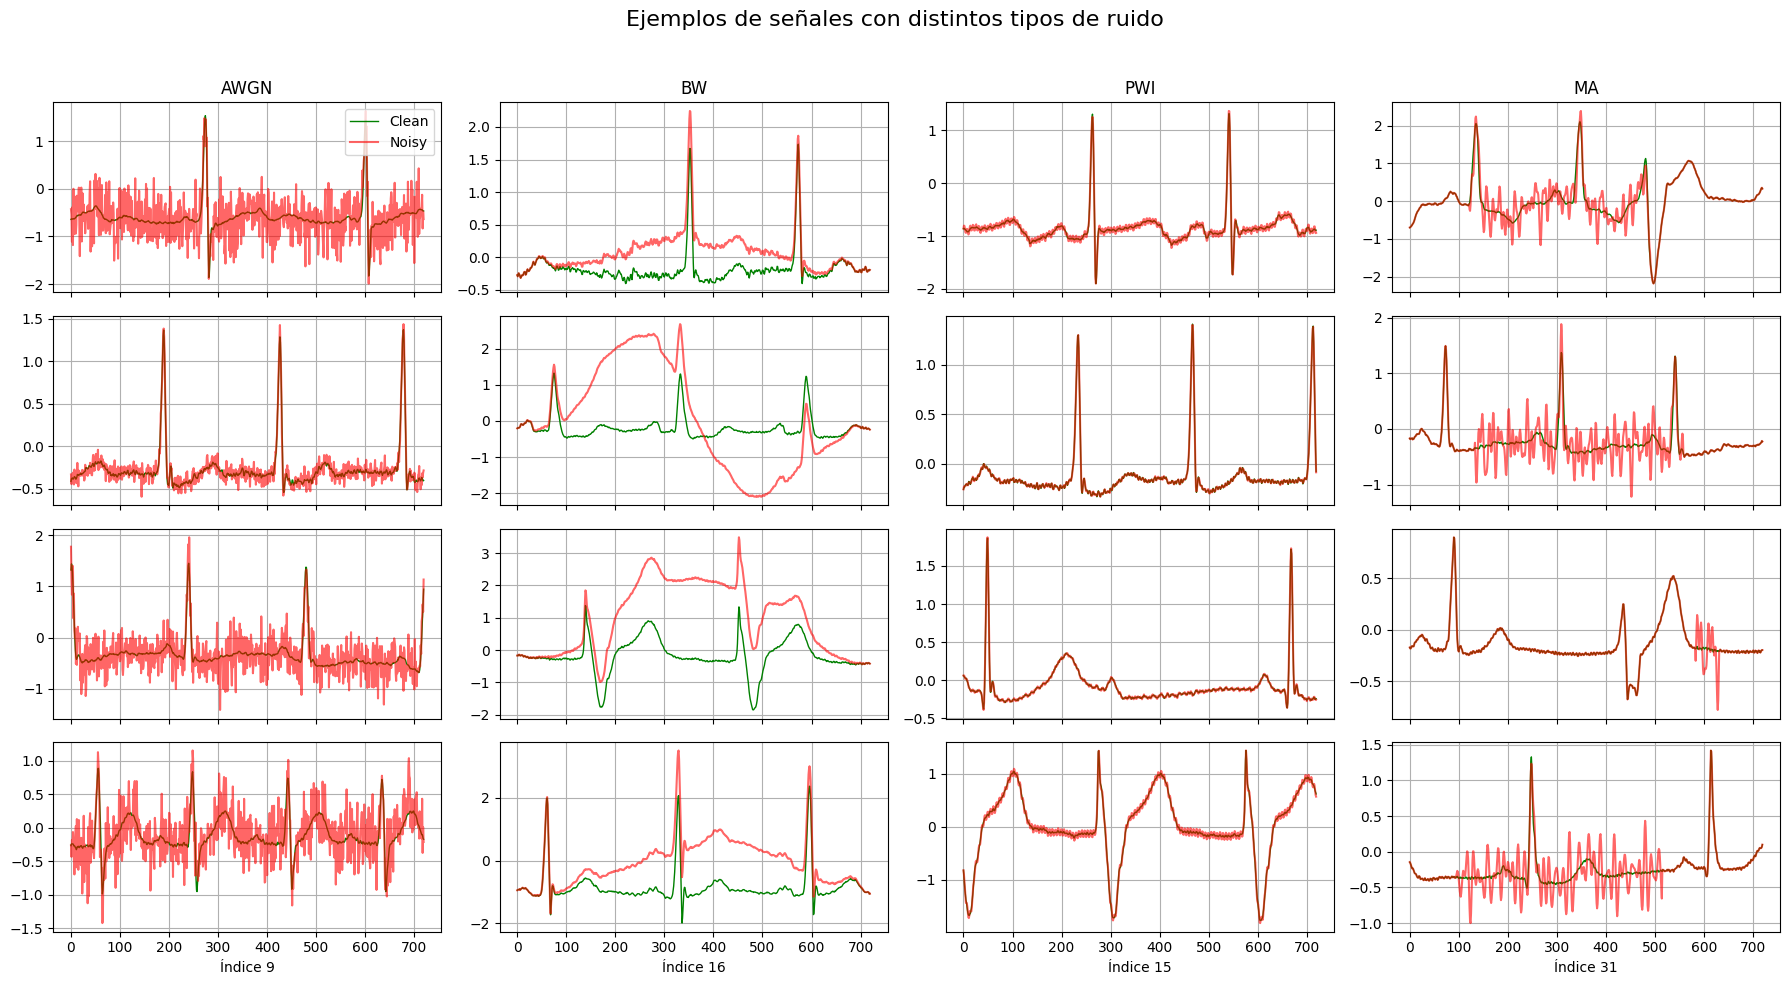

In [13]:

indices_por_ruido = {tipo: [] for tipo in ['AWGN', 'BW', 'PWI', 'MA']}


for idx, ruido in enumerate(noise_types_val):
    if len(indices_por_ruido[ruido]) < 4:
        indices_por_ruido[ruido].append(idx)
    if all(len(v) == 4 for v in indices_por_ruido.values()):
        break  


fig, axes = plt.subplots(4, 4, figsize=(18, 10), sharex=True)


fig.suptitle("Ejemplos de señales con distintos tipos de ruido", fontsize=16)

tipos = ['AWGN', 'BW', 'PWI', 'MA']

for col, tipo in enumerate(tipos):
    for row in range(4):
        idx = indices_por_ruido[tipo][row]
        ax = axes[row, col]
        ax.plot(y_val[idx].squeeze(), label='Clean', color='green', linewidth=1)
        ax.plot(X_val[idx].squeeze(), label='Noisy', color='red', alpha=0.6)
        if row == 0:
            ax.set_title(tipo)
        if row == 3:
            ax.set_xlabel(f"Índice {idx}")
        ax.grid(True)

axes[0, 0].legend(loc='upper right')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Creamos la estructura de la UNET.
- Etapa de encoder : 

c1 : 2xConv1D - Alimentamos con 1x720. Usamos 64 filtros para detectar patrones iniciales

p1 : Maxpool para reducir dimensiones a la mitad (1x360 y 64 filtros)

c2 :  2xConv1D - Duplicamos filtros (1x360 y 128 filtros)

p2 : Maxpool a la mitad (1x180 y 128 filtros)

c3 :  2xConv1D - Añadimos el doble de filtros (1x180 - 256 filtros)

p3 : Maxpool (1x90 - 256 filtros)

c4 : Bottleneck - ABSTRACCIÓN MÁXIMA DE CARACTERÍSTICAS (1x90 - 512 filtros)

- Etapa decoder

u3 : Upsampling duplicamps resolución (1x180 - 512 filtros)

concat c3 : Concatenamos con la salida del encoder c3 (1x180 - 512+256 = 768 filtros)

c5 : 2xConv1D - Reducimos a 256 filtros (1x180 - 256 filtros)

u2 : Upsampling duplicamps resolución (1x360 - 256 filtros)

concat c2 : Concatenamos con la salida del encoder c2 (1x360 - 256+128 = 384 filtros)

c6 : 2xConv1D - Reducimos a 128 filtros (1x360 - 128 filtros)

u1 : Upsampling duplicamps resolución (1x720 - 128 filtros)

concat c1 : Concatenamos con la salida del encoder c1 (1x720 - 128+64 = 192 filtros)

c7 : 2xConv1D - Reducimos a 64 filtros (1x720 - 64 filtros)

output : Conv1D(1 filtro, kernel=1) - Salida final con forma original (1x720)

In [14]:
def unet_1d(input_shape=(720, 1)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    # Bloque 1
    c1 = layers.Conv1D(64, 3, padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Activation('relu')(c1)
    c1 = layers.Conv1D(64, 3, padding='same')(c1)
    c1 = layers.Activation('relu')(c1)
    p1 = layers.MaxPooling1D(2)(c1)

    # Bloque 2
    c2 = layers.Conv1D(128, 3, padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Activation('relu')(c2)
    c2 = layers.Conv1D(128, 3, padding='same')(c2)
    c2 = layers.Activation('relu')(c2)
    p2 = layers.MaxPooling1D(2)(c2)

    # Bloque 3
    c3 = layers.Conv1D(256, 3, padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Activation('relu')(c3)
    c3 = layers.Conv1D(256, 3, padding='same')(c3)
    c3 = layers.Activation('relu')(c3)
    p3 = layers.MaxPooling1D(2)(c3)

    # Bottleneck (Bloque 4)
    c4 = layers.Conv1D(512, 3, padding='same')(p3)
    c4 = layers.Activation('relu')(c4)
    c4 = layers.Conv1D(512, 3, padding='same')(c4)
    c4 = layers.Activation('relu')(c4)

    # Decoder
    # Bloque 5 (Upsampling + Concat + Conv)
    u3 = layers.UpSampling1D(2)(c4)
    u3 = layers.Concatenate()([u3, c3]) # Skip connection de c3
    c5 = layers.Conv1D(256, 3, padding='same')(u3)
    c5 = layers.Activation('relu')(c5)
    c5 = layers.Conv1D(256, 3, padding='same')(c5)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Activation('relu')(c5)

    # Bloque 6
    u2 = layers.UpSampling1D(2)(c5)
    u2 = layers.Concatenate()([u2, c2]) # Skip connection de c2
    c6 = layers.Conv1D(128, 3, padding='same')(u2)
    c6 = layers.Activation('relu')(c6)
    c6 = layers.Conv1D(128, 3, padding='same')(c6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Activation('relu')(c6)

    # Bloque 7
    u1 = layers.UpSampling1D(2)(c6)
    u1 = layers.Concatenate()([u1, c1]) # Skip connection de c1
    c7 = layers.Conv1D(64, 3, padding='same')(u1)
    c7 = layers.Activation('relu')(c7)
    c7 = layers.Conv1D(64, 3, padding='same')(c7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Activation('relu')(c7)

    outputs = layers.Conv1D(1, 1, activation='linear')(c7) # Sin BatchNormalization ni Dropout en la capa de salida directa

    return models.Model(inputs, outputs)


In [15]:
model = unet_1d(input_shape=(720, 1))
model.compile(optimizer='adam', 
              loss='mean_squared_error', 
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

early_stop = callbacks.EarlyStopping(
    monitor='val_loss',       
    patience=5,               
    restore_best_weights=True 
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=100,
    callbacks=[early_stop],
    verbose=1
)

I0000 00:00:1747769395.211186   36168 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
2025-05-20 21:30:04.359544: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 787083840 exceeds 10% of free system memory.
2025-05-20 21:30:06.696154: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 787083840 exceeds 10% of free system memory.
2025-05-20 21:30:08.467384: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 787083840 exceeds 10% of free system memory.
2025-05-20 21:30:08.757003: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 787083840 exceeds 10% of free system memory.


Epoch 1/100


I0000 00:00:1747769412.815543   38539 service.cc:152] XLA service 0x7ef6ec0075e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747769412.816181   38539 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-05-20 21:30:12.956681: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747769413.731839   38539 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-20 21:30:19.152710: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng26{k2=0,k4=2,k5=1,k6=0,k7=0,k19=1} for conv %cudnn-conv-bw-input.16 = (f32[100,384,1,360]{3,2,1,0}, u8[0]{0}) custom-call(f32[100,128,1,360]{3,2,1,0} %bitcast.10444, f32[128,384,1,3]{3,2,1,0} %bitcast.10446), window={size=1x3 pad=0_0x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput

2732/2733 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0522 - root_mean_squared_error: 0.2195

2025-05-20 21:32:49.458180: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 17.60GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-20 21:32:49.579209: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 32.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-20 21:32:49.638520: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-20 21:32:49.815592: W external/local_xla/xla

2733/2733 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0522 - root_mean_squared_error: 0.2195

2025-05-20 21:32:53.503261: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 168661440 exceeds 10% of free system memory.


2733/2733 ━━━━━━━━━━━━━━━━━━━━ 176s 58ms/step - loss: 0.0522 - root_mean_squared_error: 0.2195 - val_loss: 0.0214 - val_root_mean_squared_error: 0.1464
Epoch 2/100
2733/2733 ━━━━━━━━━━━━━━━━━━━━ 152s 56ms/step - loss: 0.0216 - root_mean_squared_error: 0.1468 - val_loss: 0.0159 - val_root_mean_squared_error: 0.1260
Epoch 3/100
2733/2733 ━━━━━━━━━━━━━━━━━━━━ 149s 54ms/step - loss: 0.0173 - root_mean_squared_error: 0.1317 - val_loss: 0.0179 - val_root_mean_squared_error: 0.1336
Epoch 4/100
2733/2733 ━━━━━━━━━━━━━━━━━━━━ 149s 54ms/step - loss: 0.0145 - root_mean_squared_error: 0.1204 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1170
Epoch 5/100
2733/2733 ━━━━━━━━━━━━━━━━━━━━ 152s 56ms/step - loss: 0.0132 - root_mean_squared_error: 0.1150 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1151
Epoch 6/100
2733/2733 ━━━━━━━━━━━━━━━━━━━━ 148s 54ms/step - loss: 0.0119 - root_mean_squared_error: 0.1092 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1139
Epoch 7/100
2733/2733 ━━━━━━

## Cargar modelo y plotear datos

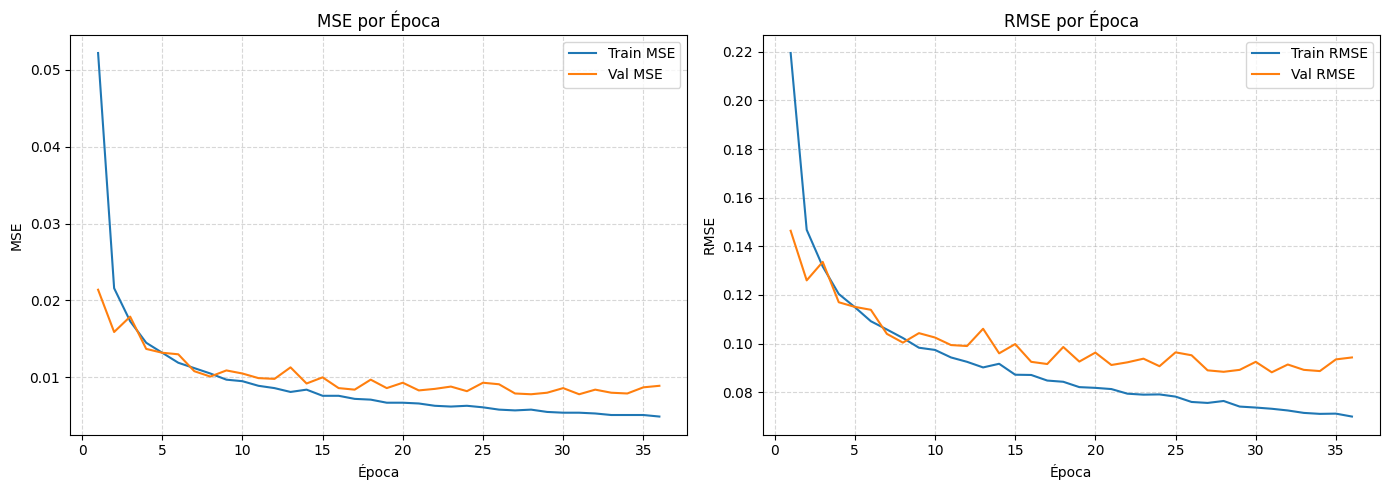

In [14]:
model = models.load_model("ecg_denoising_unet_v_final_.keras")

loss = [
    0.0522, 0.0216, 0.0173, 0.0145, 0.0132, 0.0119, 0.0112, 0.0105,
    0.0097, 0.0095, 0.0089, 0.0086, 0.0081, 0.0084, 0.0076, 0.0076,
    0.0072, 0.0071, 0.0067, 0.0067, 0.0066, 0.0063, 0.0062, 0.0063,
    0.0061, 0.0058, 0.0057, 0.0058, 0.0055, 0.0054, 0.0054, 0.0053,
    0.0051, 0.0051, 0.0051, 0.0049
]
val_loss = [
    0.0214, 0.0159, 0.0179, 0.0137, 0.0132, 0.0130, 0.0108, 0.0101,
    0.0109, 0.0105, 0.0099, 0.0098, 0.0113, 0.0092, 0.0100, 0.0086,
    0.0084, 0.0097, 0.0086, 0.0093, 0.0083, 0.0085, 0.0088, 0.0082,
    0.0093, 0.0091, 0.0079, 0.0078, 0.0080, 0.0086, 0.0078, 0.0084,
    0.0080, 0.0079, 0.0087, 0.0089
]
rmse = [
    0.2195, 0.1468, 0.1317, 0.1204, 0.1150, 0.1092, 0.1058, 0.1023,
    0.0983, 0.0974, 0.0943, 0.0925, 0.0902, 0.0917, 0.0872, 0.0871,
    0.0848, 0.0843, 0.0821, 0.0818, 0.0813, 0.0794, 0.0790, 0.0791,
    0.0782, 0.0760, 0.0756, 0.0764, 0.0741, 0.0737, 0.0732, 0.0725,
    0.0715, 0.0711, 0.0712, 0.0700
]
val_rmse = [
    0.1464, 0.1260, 0.1336, 0.1170, 0.1151, 0.1139, 0.1040, 0.1004,
    0.1043, 0.1025, 0.0994, 0.0990, 0.1061, 0.0960, 0.0998, 0.0925,
    0.0916, 0.0986, 0.0926, 0.0963, 0.0912, 0.0923, 0.0938, 0.0907,
    0.0964, 0.0952, 0.0890, 0.0884, 0.0892, 0.0925, 0.0882, 0.0914,
    0.0892, 0.0887, 0.0935, 0.0943
]

# Creamos un rango de épocas
epochs = range(1, len(loss) + 1)

# Creamos la figura con dos subplots lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Izquierda: MSE (loss)
ax1.plot(epochs, loss,        label='Train MSE')
ax1.plot(epochs, val_loss,    label='Val MSE')
ax1.set_title('MSE por Época')
ax1.set_xlabel('Época')
ax1.set_ylabel('MSE')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.5)

# Derecha: RMSE
ax2.plot(epochs, rmse,        label='Train RMSE')
ax2.plot(epochs, val_rmse,    label='Val RMSE')
ax2.set_title('RMSE por Época')
ax2.set_xlabel('Época')
ax2.set_ylabel('RMSE')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

NameError: name 'history' is not defined

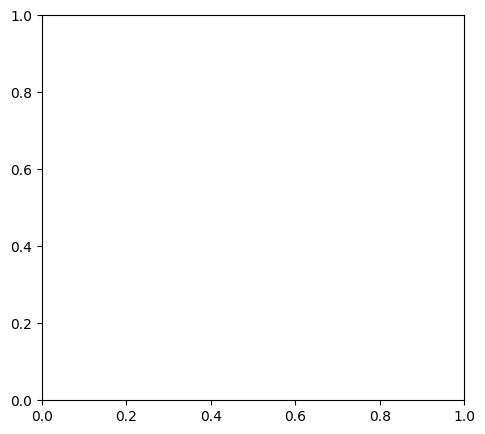

In [12]:
# Pérdida (loss)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Pérdida (Loss) por época')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# RMSE
plt.subplot(1, 2, 2)
plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.title('RMSE por época')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Guardamos el modelo

In [17]:
model.save("ecg_denoising_unet_v_final_.keras")

In [18]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 720, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 720, 64)   │        256 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 720, 64)   │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 720, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 720, 64)   │     12,352 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 720, 64)   │          0 │ conv1d_1[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 360, 64)   │          0 │ activation_1[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 360, 128)  │     24,704 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 360, 128)  │        512 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 360, 128)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 360, 128)  │     49,280 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 360, 128)  │          0 │ conv1d_3[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 180, 128)  │          0 │ activation_3[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 180, 256)  │     98,560 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 180, 256)  │      1,024 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 180, 256)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 180, 256)  │    196,864 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 180, 256)  │          0 │ conv1d_5[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 90, 256)   │          0 │ activation_5[0][

 Total params: 7,794,693 (29.73 MB)

 Trainable params: 2,597,633 (9.91 MB)

 Non-trainable params: 1,792 (7.00 KB)

 Optimizer params: 5,195,268 (19.82 MB)

I0000 00:00:1747834835.919905    2549 service.cc:152] XLA service 0x7fc4a400eb10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747834835.919969    2549 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-05-21 15:40:35.950007: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747834836.072656    2549 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


I0000 00:00:1747834837.679445    2549 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


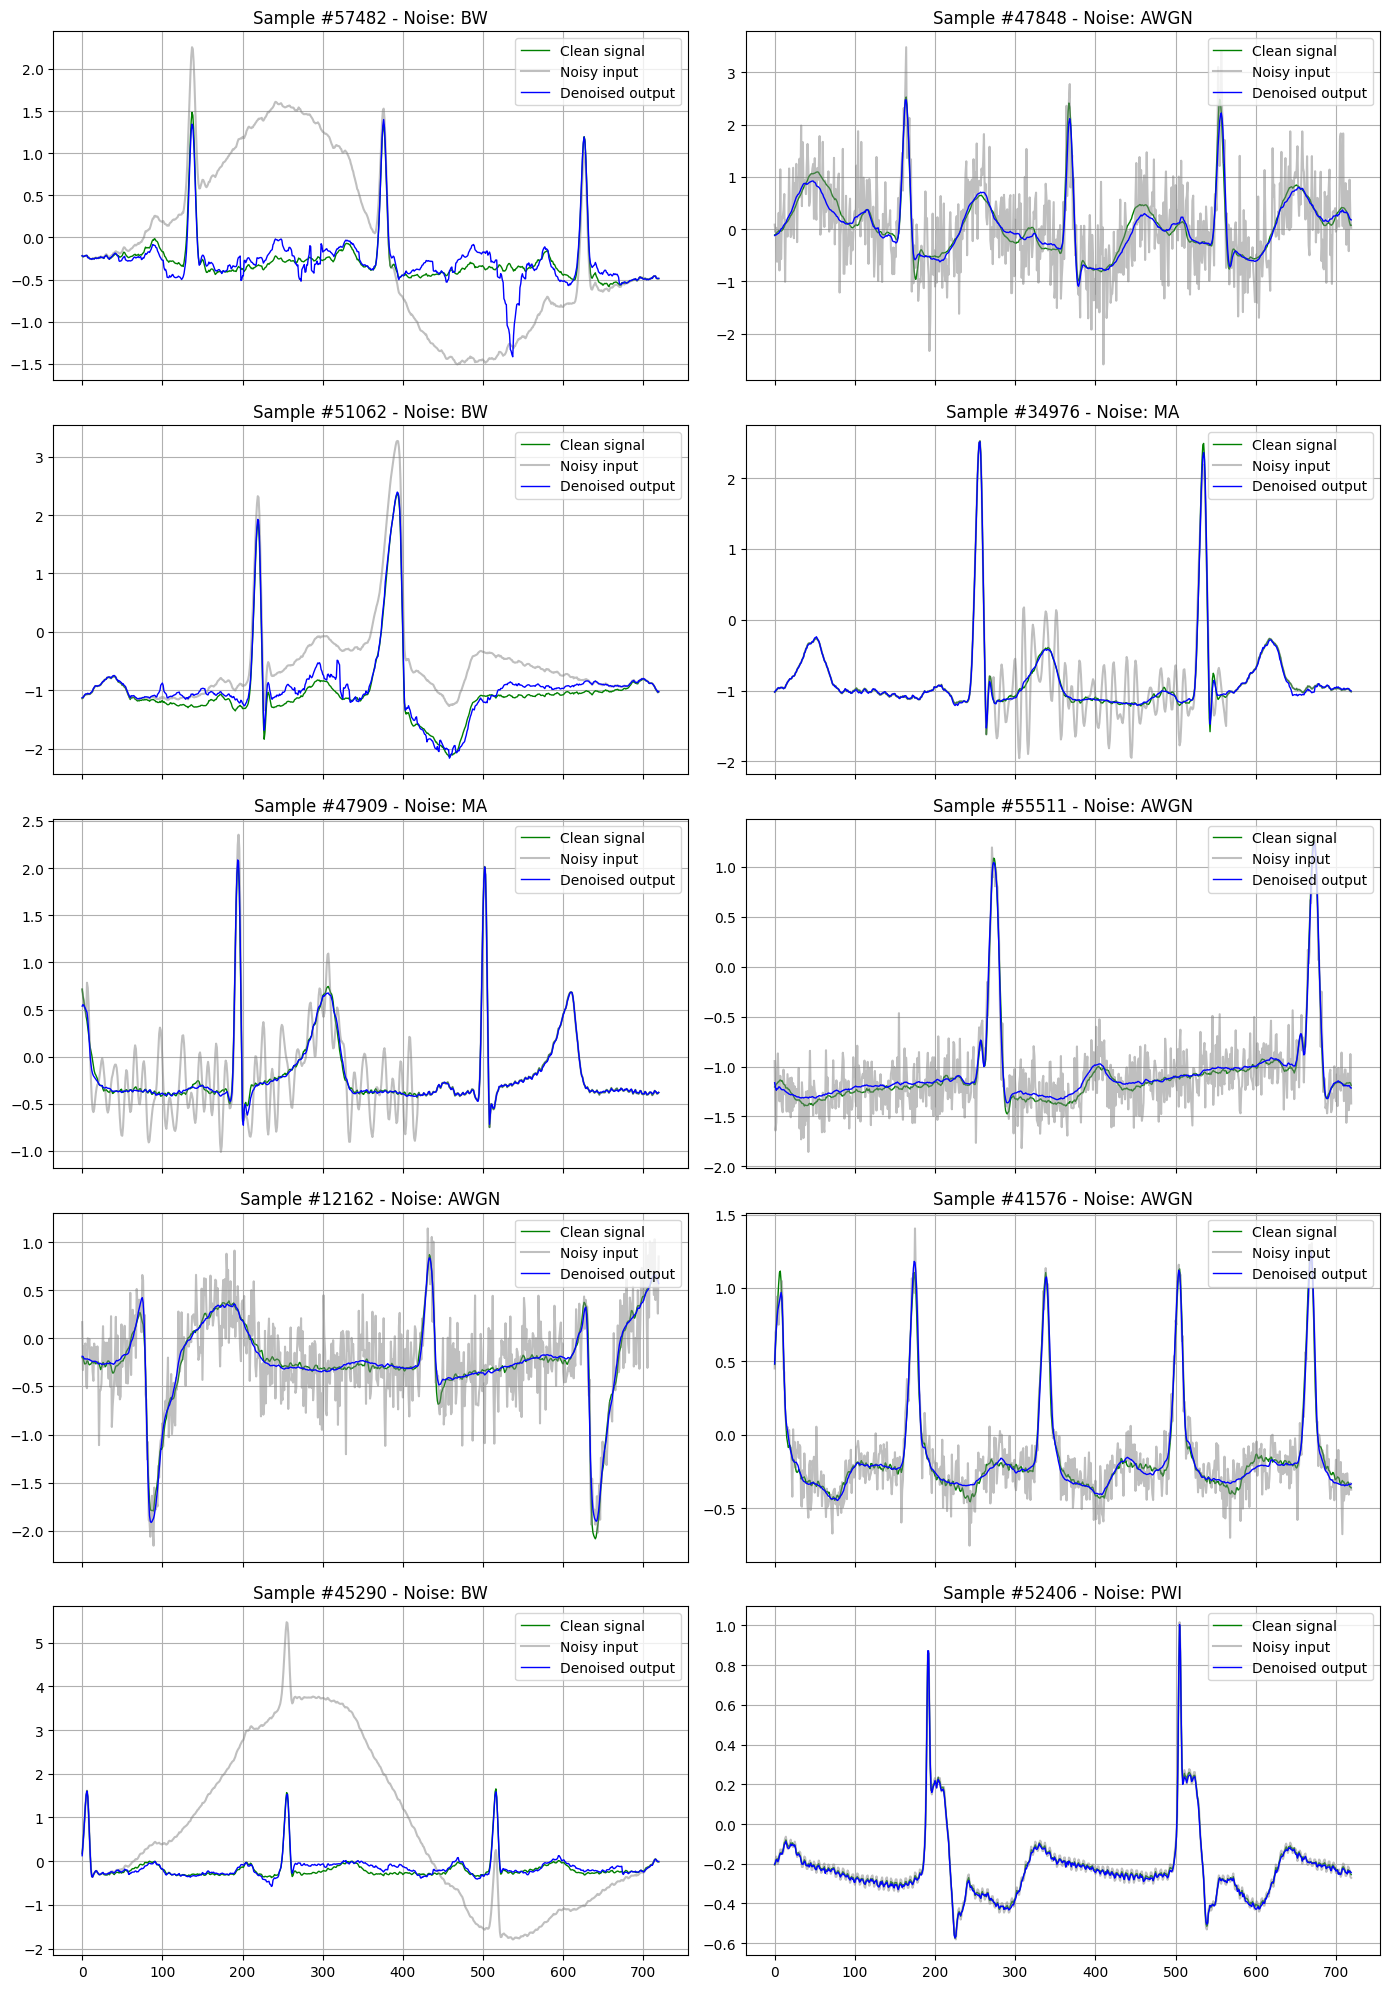

In [15]:
indices = np.random.choice(len(X_val), size=10, replace=False)

predictions = model.predict(X_val[indices])

fig, axes = plt.subplots(5, 2, figsize=(14, 20), sharex=True)

axes = axes.flatten()

for j, idx in enumerate(indices):
    ax = axes[j]
    ax.plot(y_val[idx].squeeze(), label='Clean signal', color='green', linewidth=1)
    ax.plot(X_val[idx].squeeze(), label='Noisy input', color='gray', alpha=0.5)
    ax.plot(predictions[j].squeeze(), label='Denoised output', color='blue', linewidth=1)
    ax.set_title(f'Sample #{idx} - Noise: {noise_types_val[idx]}')
    ax.legend(loc='upper right')
    ax.grid(True)

plt.tight_layout()
plt.show()


              count       mean       std        min        25%        50%  \
Noise_Type                                                                  
AWGN        14734.0   7.509149  5.559473  -0.705627   4.510385   9.465597   
BW          14664.0  -6.993491  6.636481 -24.619382 -11.955174  -7.509374   
MA          14672.0  10.134644  5.181454  -5.522228   6.091202   9.852150   
PWI         14493.0  28.017501  2.889816  23.010346  25.511744  28.012056   

                  75%        max  
Noise_Type                        
AWGN        10.500826  15.834804  
BW          -2.518408  16.991546  
MA          13.793925  34.206493  
PWI         30.528165  33.010191  


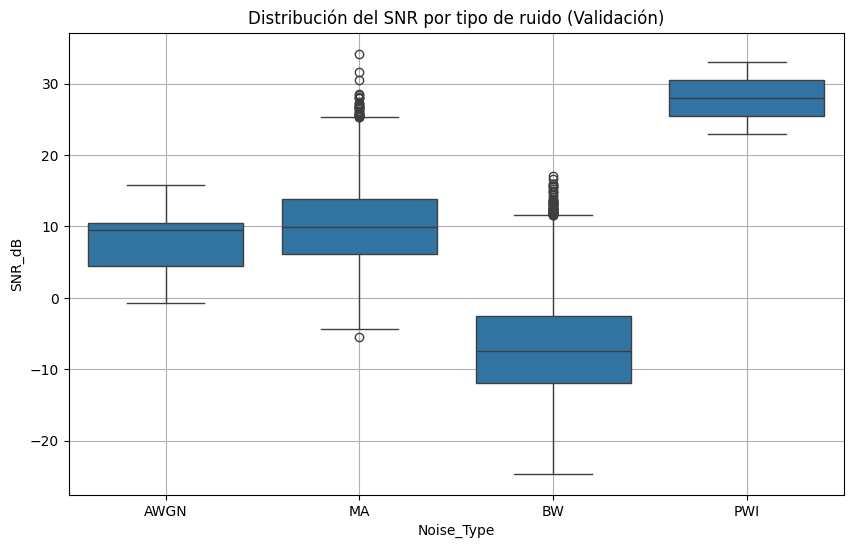

In [16]:
X_val_flat = X_val.squeeze()
y_val_flat = y_val.squeeze()

snr_values = []
for i in range(len(X_val_flat)):
    clean = y_val_flat[i]
    noisy = X_val_flat[i]
    noise = noisy - clean

    signal_power = calculate_power(clean)
    noise_power = calculate_power(noise)
    snr_db = 10 * np.log10(signal_power / noise_power)

    snr_values.append(snr_db)

# Agrupar por tipo de ruido
df_snr = pd.DataFrame({
    'SNR_dB': snr_values,
    'Noise_Type': noise_types_val
})

# Mostrar SNR medio por tipo de ruido
print(df_snr.groupby("Noise_Type")["SNR_dB"].describe())

# Si quieres plotearlo también:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_snr, x='Noise_Type', y='SNR_dB')
plt.title("Distribución del SNR por tipo de ruido (Validación)")
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


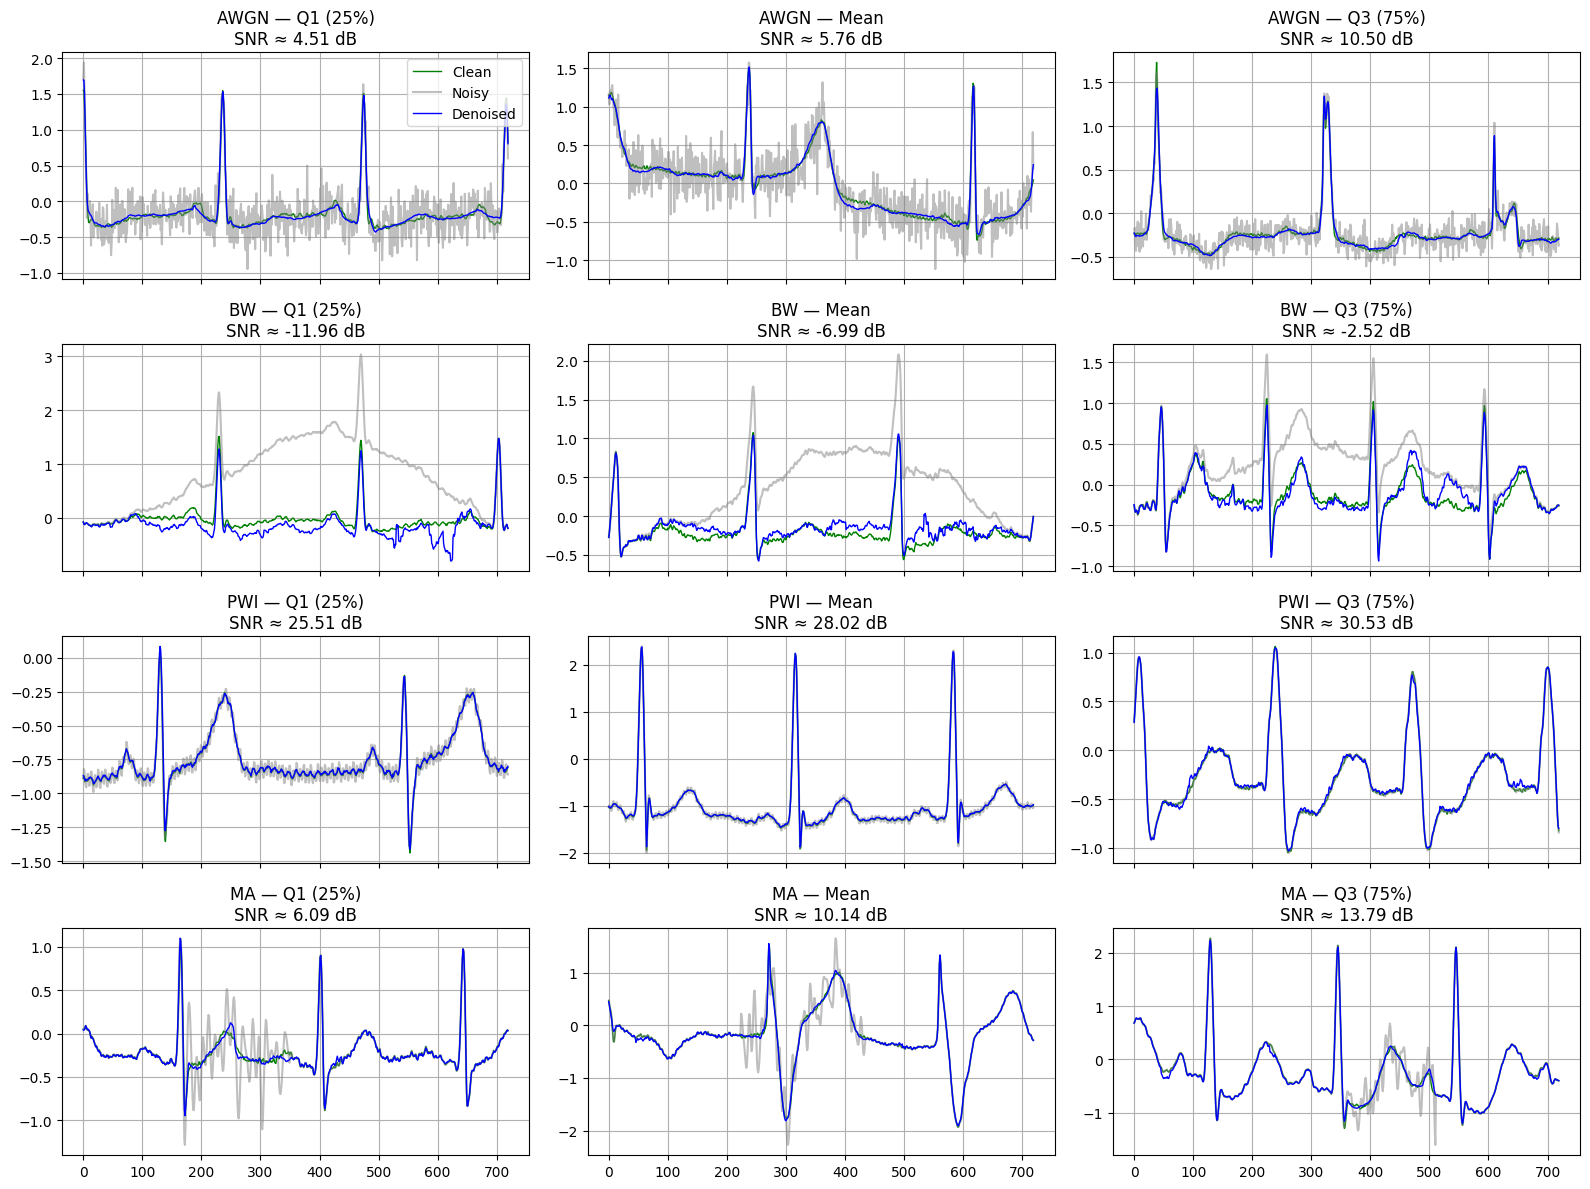

In [17]:


df_snr["Index"] = df_snr.index

selected_indices = []


for noise_type, group in df_snr.groupby("Noise_Type"):

    q1_val   = group["SNR_dB"].quantile(0.25)
    mean_val = group["SNR_dB"].mean()
    q3_val   = group["SNR_dB"].quantile(0.75)


    idx_q1   = group.iloc[(group["SNR_dB"] - q1_val  ).abs().argsort().iloc[0]]["Index"]
    idx_mean = group.iloc[(group["SNR_dB"] - mean_val).abs().argsort().iloc[0]]["Index"]
    idx_q3   = group.iloc[(group["SNR_dB"] - q3_val  ).abs().argsort().iloc[0]]["Index"]

    selected_indices.append((noise_type, int(idx_q1),   "Q1 (25%)"))
    selected_indices.append((noise_type, int(idx_mean), "Mean"))
    selected_indices.append((noise_type, int(idx_q3),   "Q3 (75%)"))


noise_types_order = ["AWGN", "BW", "PWI", "MA"]
labels_order      = ["Q1 (25%)", "Mean", "Q3 (75%)"]

fig, axes = plt.subplots(
    nrows=len(noise_types_order),
    ncols=len(labels_order),
    figsize=(16, 12),
    sharex=True
)

for noise_type in noise_types_order:
    for col_idx, label in enumerate(labels_order):

        idx = next(idx for nt, idx, lbl in selected_indices
                   if nt == noise_type and lbl == label)

        clean    = y_val[idx].squeeze()
        noisy    = X_val[idx].squeeze()
        denoised = model.predict(X_val[idx:idx+1])[0].squeeze()
        snr      = df_snr.loc[idx, "SNR_dB"]

        ax = axes[noise_types_order.index(noise_type), col_idx]
        ax.plot(clean,    label="Clean",    color="green", linewidth=1)
        ax.plot(noisy,    label="Noisy",    color="gray",  alpha=0.5)
        ax.plot(denoised, label="Denoised", color="blue",  linewidth=1)
        ax.set_title(f"{noise_type} — {label}\nSNR ≈ {snr:.2f} dB")
        ax.grid(True)

# solo una leyenda general
axes[0,0].legend(loc="upper right")

plt.tight_layout()
plt.show()

### Prueba con las lecturas del ECG. 

Hacemos un test rápido con las lecturar del ECG versión 0. 

Frecuencia de muestreo: 500 Hz
Total de segmentos: 224


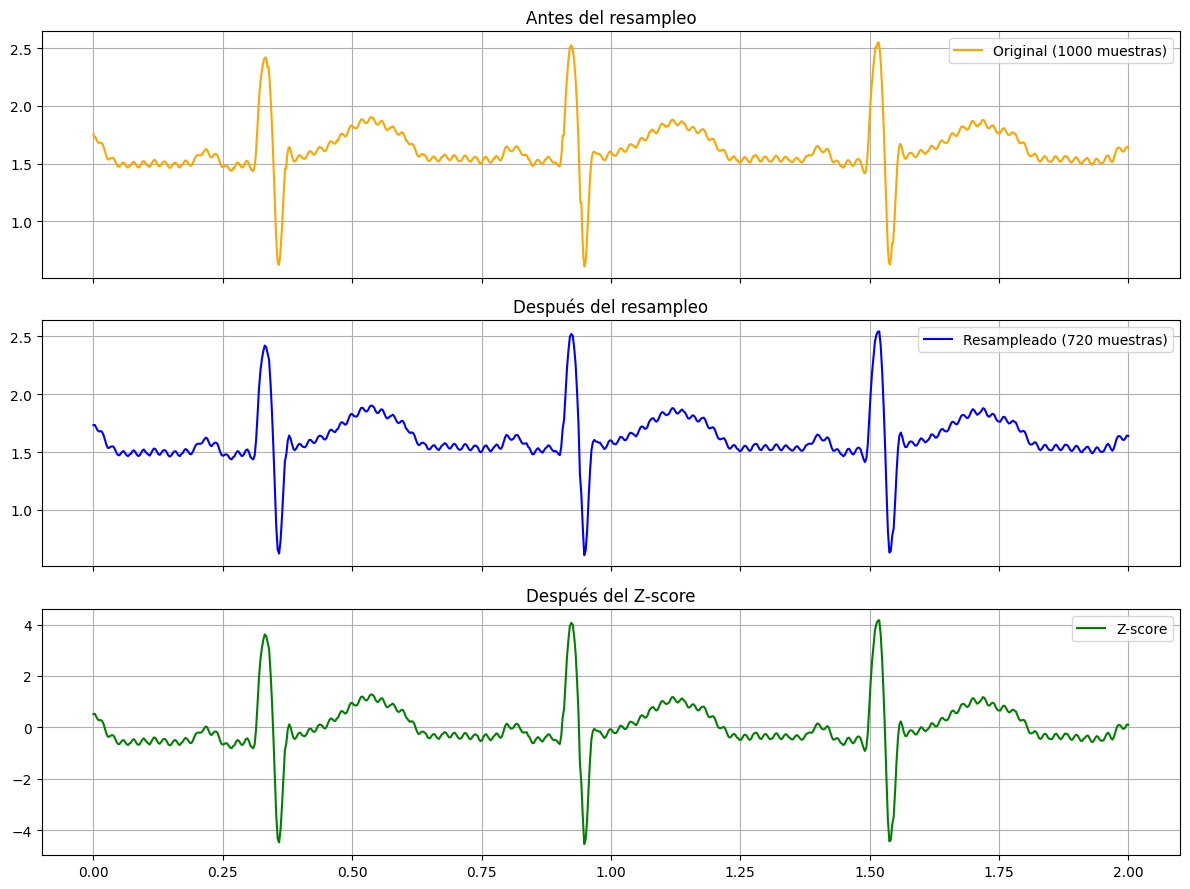

In [80]:

with open("ecg_v0_datas/0.pk", "rb") as f:
    data = pickle.load(f)

df = data["DataFrame"]
signal = df["Voltage"].values
fs = data["Metadata"]["Sample_Rate"]
print(f"Frecuencia de muestreo: {fs} Hz")


segment_length = 1000
segments = [
    signal[i:i + segment_length]
    for i in range(0, len(signal), segment_length)
    if len(signal[i:i + segment_length]) == segment_length
]
print(f"Total de segmentos: {len(segments)}")


segments_resampled = [resample(seg, 720) for seg in segments]
segments_zscore = [zscore(seg) for seg in segments_resampled]

t_original = np.linspace(0, 2, 1000)
t_resampled = np.linspace(0, 2, 720)

fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

axes[0].plot(t_original, segments[0], label="Original (1000 muestras)", color='orange')
axes[0].set_title("Antes del resampleo")
axes[0].legend()
axes[0].grid()

axes[1].plot(t_resampled, segments_resampled[0], label="Resampleado (720 muestras)", color='blue')
axes[1].set_title("Después del resampleo")
axes[1].legend()
axes[1].grid()

axes[2].plot(t_resampled, segments_zscore[0], label="Z-score", color='green')
axes[2].set_title("Después del Z-score")
axes[2].legend()
axes[2].grid()

plt.tight_layout()
plt.show()

In [83]:


# Asegurarse de que los datos estén en el formato adecuado (N, 720, 1)
X_input = np.array(segments_zscore)[..., np.newaxis]

# Pasar por la red neuronal
X_denoised = model.predict(X_input).squeeze()  # (N, 720)



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


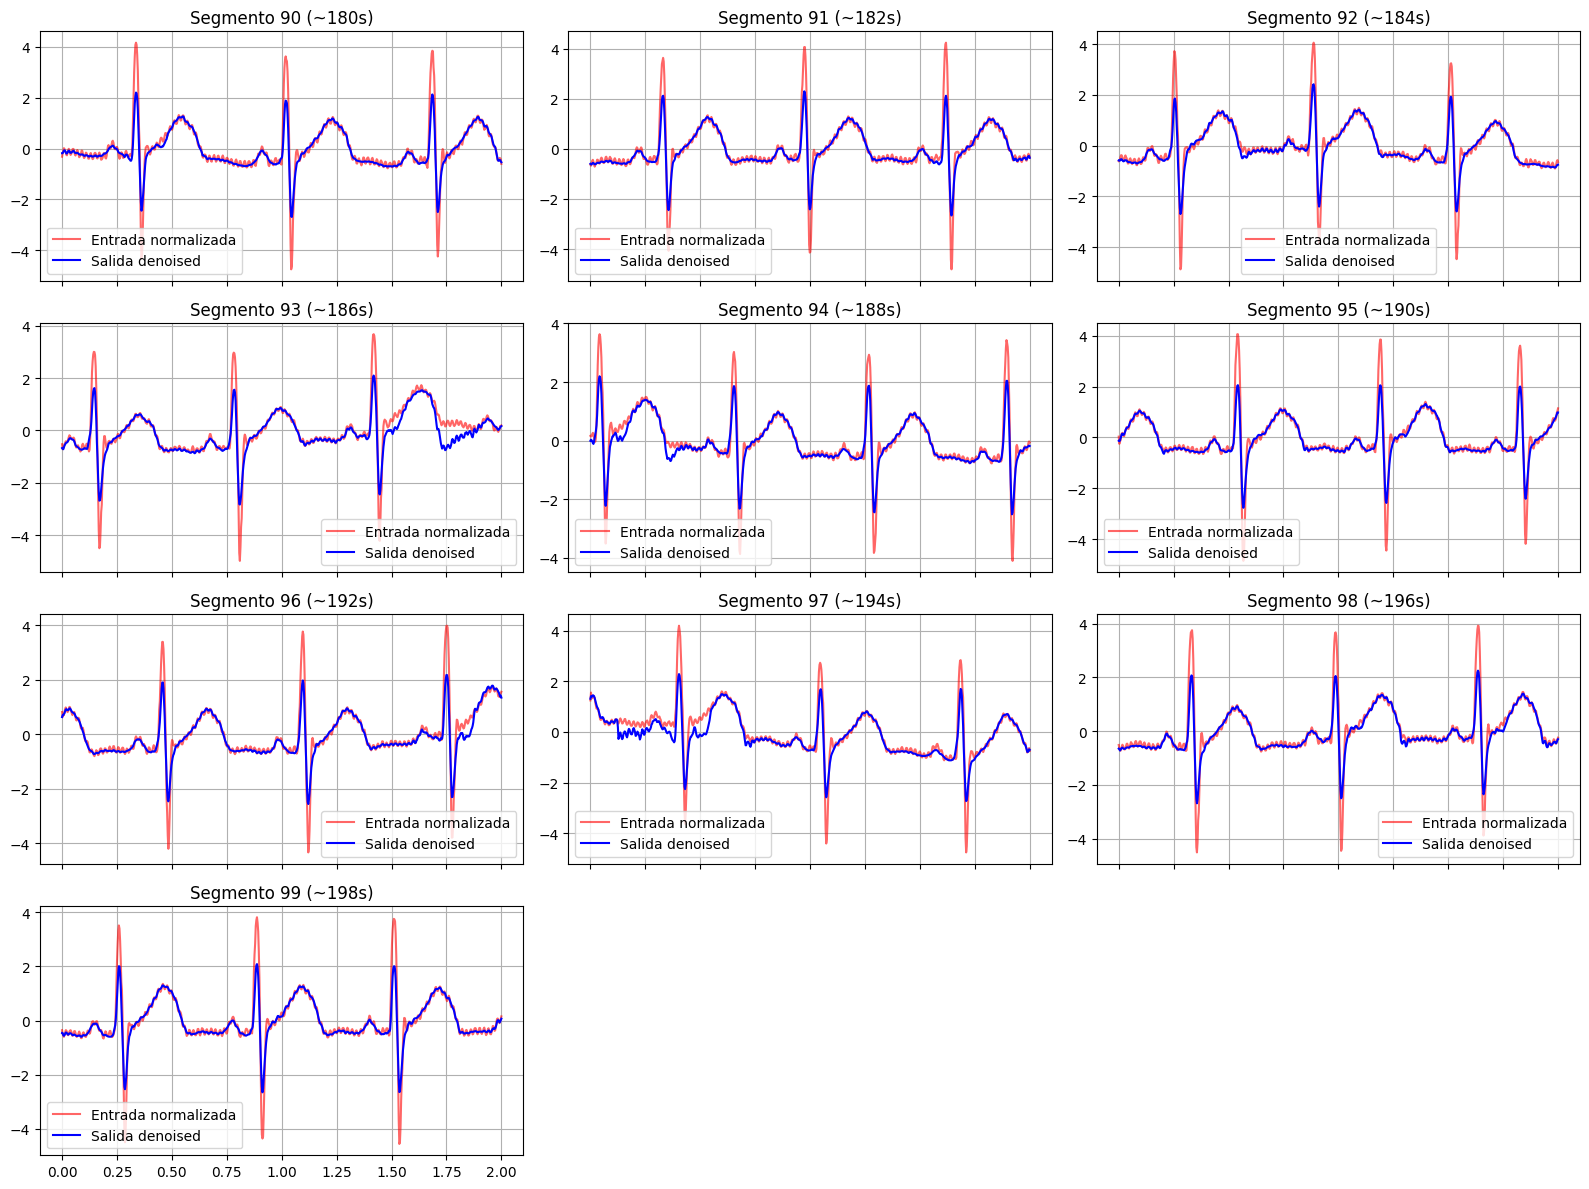

In [84]:
start_idx = 90  # corresponde a ~segundo 967
num_plots = 10
indices = list(range(start_idx, start_idx + num_plots))

fig, axes = plt.subplots(4, 3, figsize=(16, 12), sharex=True)
axes = axes.flatten()

for i, idx in enumerate(indices):
    if idx >= len(X_input):
        print(f"Índice {idx} fuera de rango. Saltando.")
        continue

    t = np.linspace(0, 2, 720)
    ax = axes[i]
    ax.plot(t, segments_zscore[idx], label="Entrada normalizada", alpha=0.6, color='red')
    ax.plot(t, X_denoised[idx], label="Salida denoised", linewidth=1.5, color='blue')
    ax.set_title(f"Segmento {idx} (~{idx*2}s)")
    ax.grid(True)
    ax.legend()

# Ocultar subplots vacíos si hay menos de 12
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [21]:
def calculate_power(sig: np.ndarray) -> float:
    return np.mean(sig ** 2)

def calculate_snr_db(clean: np.ndarray, noisy: np.ndarray) -> float:
    noise = noisy - clean
    p_signal = calculate_power(clean)
    p_noise  = calculate_power(noise)
    return 10 * np.log10(p_signal / p_noise)


record100 = wfdb.rdrecord('100', pn_dir='mitdb')
signal_100_clean_full = record100.p_signal[:, 0]  

record103 = wfdb.rdrecord('103', pn_dir='mitdb')
signal_103_clean_full = record103.p_signal[:, 0]  


segment_length = 720
snr_levels_db  = [0, 5, 10]

results = []

signals_to_process = {
    "100": signal_100_clean_full,
    "103": signal_103_clean_full
}

for record_name, clean_full in signals_to_process.items():
    print(f"\nProcesando registro: {record_name}")

    clean_segments = [
        clean_full[i:i + segment_length]
        for i in range(0, len(clean_full) - segment_length + 1, segment_length)
    ]
    clean_segments = np.array(clean_segments)

    for snr_db in snr_levels_db:
        print(f"Añadiendo AWGN con SNR = {snr_db} dB")
        noisy_full = add_awgn_snr(signal=clean_full, snr_db=snr_db)

        noisy_segments = [
            noisy_full[i:i + segment_length]
            for i in range(0, len(noisy_full) - segment_length + 1, segment_length)
        ]
        noisy_segments = np.array(noisy_segments)

        n_seg = min(len(clean_segments), len(noisy_segments))
        clean_segs = clean_segments[:n_seg]
        noisy_segs = noisy_segments[:n_seg]

        X_input = noisy_segs[..., np.newaxis]
        print(f"Prediciendo {X_input.shape[0]} segmentos…")
        denoised_norm = model.predict(X_input).squeeze()  # (N, 720)
        if denoised_norm.ndim == 1:
            denoised_norm = denoised_norm[np.newaxis, :]

        snr_in_vals  = []
        snr_out_vals = []

        print(f"SNR por segmento…")
        for clean_seg, noisy_seg, denoised_seg in zip(clean_segs, noisy_segs, denoised_norm):

            snr_in = calculate_snr_db(clean_seg, noisy_seg)
            snr_in_vals.append(snr_in)

            snr_out = calculate_snr_db(clean_seg, denoised_seg)
            snr_out_vals.append(snr_out)


        snr_in_arr  = np.array(snr_in_vals)
        snr_out_arr = np.array(snr_out_vals)
        avg_in  = np.nanmean(snr_in_arr[np.isfinite(snr_in_arr)])
        avg_out = np.nanmean(snr_out_arr[np.isfinite(snr_out_arr)])
        imp     = avg_out - avg_in

        print(f"SNR_in avg={avg_in:.2f} dB, SNR_out avg={avg_out:.2f} dB, improv SNR={imp:.2f} dB")

        results.append({
            "record": record_name,
            "snr_awgn_db": snr_db,
            "avg_snr_input_db":  avg_in,
            "avg_snr_output_db": avg_out,
            "snr_improvement_db": imp
        })

df_results = pd.DataFrame(results)
print("\n### Resumen de Resultados por Registro y SNR ###")
display(df_results)


Procesando registro: 100
Añadiendo AWGN con SNR = 0 dB
Prediciendo 902 segmentos…
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step
SNR por segmento…
SNR_in avg=-0.08 dB, SNR_out avg=13.62 dB, improv SNR=13.70 dB
Añadiendo AWGN con SNR = 5 dB
Prediciendo 902 segmentos…
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
SNR por segmento…
SNR_in avg=4.92 dB, SNR_out avg=17.39 dB, improv SNR=12.47 dB
Añadiendo AWGN con SNR = 10 dB
Prediciendo 902 segmentos…
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
SNR por segmento…
SNR_in avg=9.91 dB, SNR_out avg=20.49 dB, improv SNR=10.57 dB

Procesando registro: 103
Añadiendo AWGN con SNR = 0 dB
Prediciendo 902 segmentos…
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
SNR por segmento…
SNR_in avg=-0.25 dB, SNR_out avg=13.67 dB, improv SNR=13.92 dB
Añadiendo AWGN con SNR = 5 dB
Prediciendo 902 segmentos…
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
SNR por segmento…
SNR_in avg=4.73 dB, SNR_out avg=17.41 dB, improv SNR=12.68 dB
Añadiendo AWGN con SNR = 10 dB
Prediciendo 902 segmentos…
29/29 

,record,snr_awgn_db,avg_snr_input_db,avg_snr_output_db,snr_improvement_db
0,100,0,-0.079700,13.618373,13.698073
1,100,5,4.918590,17.392131,12.473542
2,100,10,9.913920,20.485582,10.571662
3,103,0,-0.252164,13.666534,13.918699
4,103,5,4.725443,17.408283,12.682840
5,103,10,9.736117,20.827506,11.091390


In [23]:
df_results

,record,snr_awgn_db,avg_snr_input_db,avg_snr_output_db,snr_improvement_db
0,100,0,-0.079700,13.618373,13.698073
1,100,5,4.918590,17.392131,12.473542
2,100,10,9.913920,20.485582,10.571662
3,103,0,-0.252164,13.666534,13.918699
4,103,5,4.725443,17.408283,12.682840
5,103,10,9.736117,20.827506,11.091390
